# Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

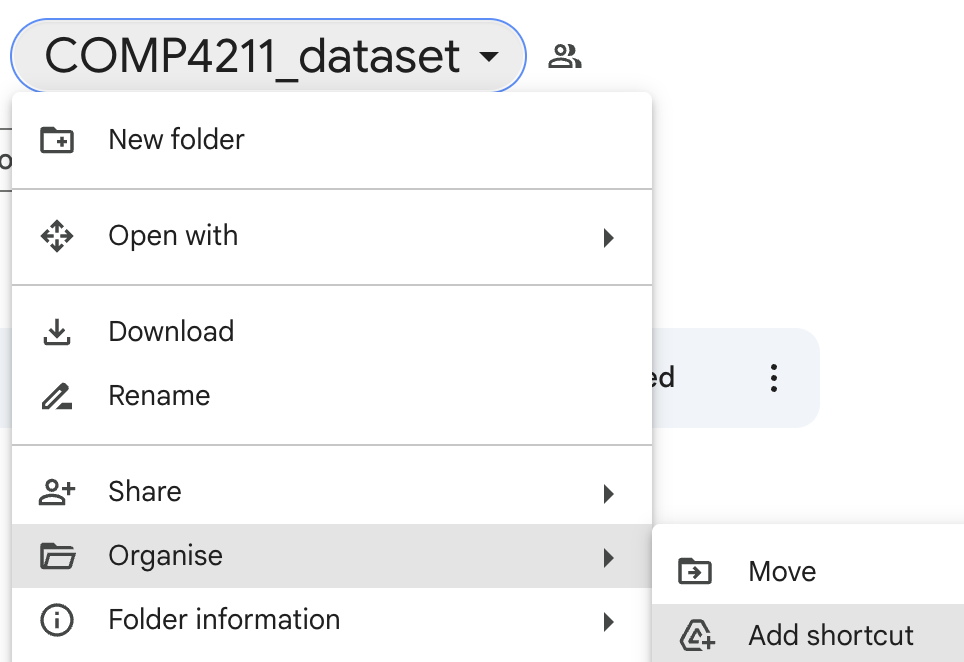

Mount the dataset by the following code (requires authorization):

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/COMP4211_dataset"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"


Mounted at /content/drive


To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [ ]:
!unzip "$wikiart_zip" > /dev/null 2>&1
!unzip "$coco_zip" > /dev/null 2>&1

(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [ ]:
# Put the PACS files in a subfolder
!mkdir -p "$pacs_path"
!unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import csv

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.optimizers import Adam

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Other utility
import datetime
import psutil

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [ ]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [ ]:
# [C1]
class ImageDataset:
    def __init__(self, dir_path, batch_size= 8, file_type="jpg", random_state = 4211):
        # [Your code here]
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.file_type = file_type
        self.random_state = np.random.RandomState(random_state)
        self.list_of_file = []
        self.ds_pointer = 0
        self.list_of_file = find_images(dir_path,file_type)
        self.random_state.shuffle(self.list_of_file)

    def reset_pointer(self, seed=None):
        # [Your code here]
        if seed != None:
          self.random_state = np.random.RandomState(seed)
        np.random.shuffle(self.list_of_file)
        self.ds_pointer = 0
    def get_batch(self):
        # [Your code here]
        batch_image = []
        if len(self.list_of_file) - self.ds_pointer < self.batch_size:
            self.ds_pointer = 0
            np.random.shuffle(self.list_of_file)
        for i in range(self.batch_size):
          path_img = self.list_of_file[self.ds_pointer]
          image = get_image(path_img)
          process_img = preprocess(image)
          batch_image.append(process_img)
          self.ds_pointer+=1
        return np.array(batch_image)
    def __len__(self):
        # [Your code here]
        return len(self.list_of_file)

In [ ]:
coco_ds = ImageDataset(coco_path,file_type = 'jpg')
coco_ds.reset_pointer()
len_coco = len(coco_ds)
print('The len of COCO is ',len_coco)

The len of COCO is  3557


In [ ]:
wiki_ds = ImageDataset(wikiart_path,file_type = 'jpg')
wiki_ds.reset_pointer()
len_wiki = len(wiki_ds)
print('The len of Wikiart is ',len_wiki)

The len of Wikiart is  7492


In [ ]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

pic_2524.jpg	sketch	dog
pic_888.jpg	sketch	dog
pic_1279.jpg	sketch	dog
pic_2694.jpg	sketch	dog
pic_79.jpg	sketch	dog
pic_650.jpg	sketch	dog
pic_2095.jpg	sketch	dog
pic_481.jpg	sketch	dog
pic_332.jpg	sketch	dog
pic_1417.jpg	sketch	dog


## Part 1: Style Transfer


In [ ]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=8, random_state = 4211):
        # [Your code here]
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.tsv_path = tsv_path
        self.random_state = np.random.RandomState(random_state)
        self.data_table = self._process_tsv(tsv_path,dir_path)
        self.list_of_file = self.data_table['file_path']
        self.list_of_label = self.data_table['label']
        self.list_of_style = self.data_table['style']
        self.list_of_onehot = self.data_table['one_hot_encoder']
        self.data_table = self.data_table.sample(frac=1, random_state=self.random_state).reset_index(drop=True)

        self.ds_pointer = 0

    # Tip: It is recommended to use this method to process the tsv data into a data table, since this will be used in both __init__() and add_data().

    def _process_tsv(self, tsv_path, dir_path):
        with open(tsv_path,'r') as tsv_file :
          tsv_reader = csv.reader(tsv_file,delimiter='\t')
          data_set = list(tsv_reader)
          #print(data_set)
        data_table = {'file_path':[],'label':[],'style':[]}
        label_set = set()
        for row in data_set:
          file_path = os.path.join(dir_path,row[0])
          style = row[1]
          label = row[2]
          data_table['file_path'].append(file_path)
          data_table['label'].append(label)
          data_table['style'].append(style)
          label_set.add(label)
        label_class = list(label_set)
        label_class.sort()
        no_label = len(label_class)
        #create a dic to store correspoing label position with index
        label_with_index = {label:index for index,label in enumerate(label_class)}
        onehot_label = np.zeros((len(data_table['label']),no_label),dtype=np.float32)
        for ind , label in enumerate(data_table['label']):
          one_hot = label_with_index[label]
          onehot_label[ind][one_hot]=1.0

        data_table['one_hot_encoder'] = onehot_label.tolist()

        df = pd.DataFrame(data_table)
        #print(df)
        return df


    def add_data(self, tsv_path, dir_path):
        # [Your code here]
        add_data_table = self._process_tsv(tsv_path, dir_path)
        self.data_table = pd.concat([self.data_table, add_data_table])
        self.reset_pointer()
    def reset_pointer(self, seed=None):
        # [Your code here]
        self.ds_pointer = 0
        self.data_table = self.data_table.sample(frac=1, random_state=self.random_state).reset_index(drop=True)

    def get_batch(self):
        # [Your code here]
        batch_image = []
        batch_label = []
        if len(self.list_of_file) - self.ds_pointer < self.batch_size:
            self.reset_pointer()
        for i in range(self.batch_size):
          path_img = self.list_of_file[self.ds_pointer]
          img = get_image(path_img)
          process_img = preprocess(img)
          batch_image.append(process_img)
          batch_label.append(self.list_of_onehot[self.ds_pointer])
          self.ds_pointer+=1

        return np.array(batch_image),np.array(batch_label)

    def __len__(self):
        # [Your code here]
        return len(self.list_of_file)

In [ ]:
pacs_data_train = ClassificationDataset(tsv_path= "/content/classify/train-data.tsv",dir_path = "/content/classify/train-files")
pacs_data_train.reset_pointer()
len_of_train = len(pacs_data_train)
print('The length of the pacs_train data is ', len_of_train)

print()

pacs_data_test = ClassificationDataset(tsv_path= "/content/classify/test-data.tsv",dir_path = "/content/classify/test-files")
pacs_data_test.reset_pointer()
len_of_test = len(pacs_data_test)
print('The length of the pacs_test data is ', len_of_test)

The length of the pacs_train data is  1641

The length of the pacs_test data is  2723


### Model Components

In [ ]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [ ]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure
    model = Sequential(name='VGG19_Enc')
    model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=input_shape,name='conv1_1'))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=input_shape,name='conv1_2'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool1'))

    model.add(Conv2D(128,(3,3),activation='relu',padding='same',name='conv2_1'))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same',name='conv2_2'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool2'))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_4'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool3'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))

    # [C4] Load in weights and freeze the model
    index = 0
    for layer in model.layers:
      if 'conv'in layer.name:

        layer_weight = np.array(weights[f'arr_{index}'])
        layer_bias = np.array(weights[f'arr_{index+1}'])
        kernel = layer_weight.transpose([2,3,1,0])
        kernel.astype(np.float32)
        layer_bias.astype(np.float32)
        layer.set_weights([kernel,layer_bias])
        index+=2
    model.trainable = False

    return model

def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
    model = Sequential(name='Decoder')
    model.add(Conv2D(256,(3,3),padding='same',activation='relu',input_shape=input_shape))
    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(3,(3,3),padding='same'))

    model.summary()
    return model


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)

    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


In [ ]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [ ]:
# [C6]
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 10, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = Adam(learning_rate=1e-4,weight_decay=5e-5) # [Your code here]

    # Calculate the number of batches per epoch
    #n_batches = min(len(content_ds),len(style_ds))
    n_batches =(len(content_ds) + content_ds.batch_size - 1) // content_ds.batch_size

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        content_ds.reset_pointer()
        style_ds.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]
            content_bat = content_ds.get_batch()
            style_bat = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.
            # [Your code here]
            with tf.GradientTape() as grad:
              output = model([content_bat,style_bat,alpha])
              loss = loss_fn((content_bat,style_bat),output)
            total_loss, content_loss, weighted_style_loss = loss
            dy_dx = grad.gradient(total_loss,model.trainable_variables)
            grad_corr = zip(dy_dx,model.trainable_variables)
            optimizer.apply_gradients(grad_corr)
            # Update Loss Metrics
            # [Your code here]
            losses["total"] = (losses["total"]*i+total_loss.numpy())/(i + 1)
            losses["content"] = (losses["content"]*i+content_loss.numpy())/(i + 1)
            losses["style"] = (losses["style"]*i+weighted_style_loss.numpy())/(i + 1)
            '''
            losses["total"] += total_loss.numpy()
            losses["content"] += content_loss.numpy()
            losses["style"] += weighted_style_loss.numpy()
            '''
            #avg_losses = {key: value / (i + 1) for key, value in losses.items()}
            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

### Model setup

In [ ]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 2.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [ ]:
content_ds, style_ds = part1_prepare_datasets()

In [ ]:
model, loss = part1_setup()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 256)   1179904   
                                                                 
 up_sampling2d (UpSampling2  (None, None, None, 256)   0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   295040    
                                                           

We can now start the training:

In [ ]:
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = "/content/drive/My Drive/Comp4211/weight/thridweight.h5" # Change to your own path.

part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH, save_interval=1)

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

In [ ]:
PART1_SAVE_PATH = "/content/drive/My Drive/Comp4211/weight/thridweight.h5" # Change to your own path.
part1_train(model, content_ds, style_ds, loss, n_epochs=1, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH ,save_interval=1)

  0%|          | 0/223 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [ ]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
  model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

  # Get content image
  # [Your code here]
  content_img = get_image(content_path)
  content_img = preprocess(content_img)
  content_img = tf.expand_dims(content_img,axis=0)

  # Get style image
  # [Your code here]
  style_img = get_image(style_path)
  style_img = preprocess(style_img)
  style_img = tf.expand_dims(style_img,axis=0)

  # Set alpha Value
  # [Your code here]
  alpha_ten =  tf.expand_dims(alpha,axis=0)

  # Do inference
  # [Your code here]
  output_img,adin = model.predict([content_img,style_img,alpha_ten])
  #print("Output shape:", output_img.shape)
  # Convert output array to image
  # [Your code here]

  output_img = tf.squeeze(output_img)
  output_img = deprocess(output_img)
  img = array_to_img(output_img)

  # Display the image in the Notebook
  display(img)

1/1 [==============================] - 2s 2s/step


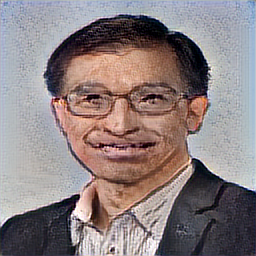

In [ ]:
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, '/content/drive/MyDrive/COMP4211_dataset/HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join(data_path, '/content/wikiart/Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

1/1 [==============================] - 0s 241ms/step


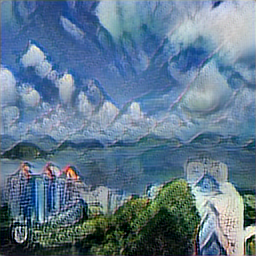

In [ ]:
# Another sample, please change and test on your own
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, '/content/drive/MyDrive/COMP4211_dataset/HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, '/content/drive/MyDrive/COMP4211_dataset/Extra_styles/the-starry-night.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [ ]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

Find out the distribution of images in diferent styles and categories:

In [ ]:
# [C8]
def part2_tally_samples(dataset):
    style_label = pd.DataFrame({'style': dataset.list_of_style, 'label': dataset.list_of_label})
    count = style_label.groupby(['style', 'label']).size().reset_index(name='count')
    return count

Compare this to the test dataset:

In [ ]:
part2_tally_samples(train_ds)

,style,label,count
0,art_painting,dog,13
1,art_painting,elephant,13
2,art_painting,giraffe,231
3,art_painting,guitar,10
4,art_painting,horse,180
5,art_painting,house,11
6,art_painting,person,11
7,cartoon,dog,10
8,cartoon,elephant,13
9,cartoon,giraffe,12


In [ ]:
part2_tally_samples(test_ds)

,style,label,count
0,art_painting,dog,119
1,art_painting,elephant,89
2,art_painting,giraffe,110
3,art_painting,guitar,82
4,art_painting,horse,90
5,art_painting,house,110
6,art_painting,person,96
7,cartoon,dog,95
8,cartoon,elephant,83
9,cartoon,giraffe,109


### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [ ]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure
    # [Your code here]
    vgg19_enc = build_vgg19_enc(input_shape, vgg_path)
    vgg19_enc.trainable = False
    #Add vgg19 encoder
    model = Sequential(name='VGG19_class')
    #Add layers
    model.add(vgg19_enc)
    model.add(GlobalAveragePooling2D(name='global_pool'))
    model.add(Dense(1024,activation='relu',name='dense1'))
    model.add(Dense(1024,activation='relu',name='dense2'))
    model.add(Dense(512,activation='relu',name='dense3'))
    model.add(Dense(num_class,activation='softmax',name='dense4'))

    model.summary()
    return model

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
from tensorflow.keras.losses import CategoricalCrossentropy
def part2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    num_class = 7
    model = build_vgg19_classifier(INPUT_SHAPE,num_class)

    # Get Loss
    loss_fn = CategoricalCrossentropy()
    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

model2, loss2 = part2_setup()

Model: "VGG19_class"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VGG19_Enc (Sequential)      (None, None, None, 512)   3505728   
                                                                 
 global_pool (GlobalAverage  (None, 512)               0         
 Pooling2D)                                                      
                                                                 
 dense1 (Dense)              (None, 1024)              525312    
                                                                 
 dense2 (Dense)              (None, 1024)              1049600   
                                                                 
 dense3 (Dense)              (None, 512)               524800    
                                                                 
 dense4 (Dense)              (None, 7)                 3591      
                                                       

### Training the model with the given dataset

In [ ]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = Adam(learning_rate=1e-4,weight_decay=5e-5) # [Your code here]

    # Calculate the number of batches per epoch

    n_batches = len(dataset)//dataset.batch_size # [Your code here]
    #print(dataset.batch_size,n_batches)
    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        dataset.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]
            data_bat,data_label = dataset.get_batch()

            # Execute Batch Training
            # [Your code here]
            with tf.GradientTape() as grad:
              output = model(data_bat,training=True)
              loss = tf.keras.losses.categorical_crossentropy(data_label, output)
            dy_dx = grad.gradient(loss,model.trainable_variables)
            grad_corr = zip(dy_dx,model.trainable_variables)
            optimizer.apply_gradients(grad_corr)
            # Update Loss Metrics
            # [Your code here]
            losses["cross-entropy"] += tf.reduce_mean(loss).numpy()

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)


In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/My Drive/Comp4211/weight/testpart2.h5" # [Change to your own path]
PART2_LOAD_PATH = "/content/drive/My Drive/Comp4211/weight/testpart2.h5"
# [Call your train function here]
part2_train(model2,train_ds,loss2,n_epochs=5,save_interval=5,save_path=PART2_SAVE_PATH,load_path=PART2_LOAD_PATH)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2, loss2 = part2_setup("/content/drive/My Drive/Comp4211/weight/testpart2.h5")

Model: "VGG19_class"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VGG19_Enc (Sequential)      (None, None, None, 512)   3505728   
                                                                 
 global_pool (GlobalAverage  (None, 512)               0         
 Pooling2D)                                                      
                                                                 
 dense1 (Dense)              (None, 1024)              525312    
                                                                 
 dense2 (Dense)              (None, 1024)              1049600   
                                                                 
 dense3 (Dense)              (None, 512)               524800    
                                                                 
 dense4 (Dense)              (None, 7)                 3591      
                                                       

### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [ ]:
train_ds.reset_pointer()

In [ ]:
# [C11]
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import CategoricalAccuracy
def part2_evaluate(model, dataset):
    # [Your code here]
    #inital need variables
    num=0
    accuracy_metric = CategoricalAccuracy()
    all_label = []
    prediction = []
    control = True
    #Iteration get batch
    while num < len(dataset.list_of_file):
      data_bat , data_label = dataset.get_batch()
      #print(data_label)
      num+=len(data_bat)
      batch_pred = model(data_bat,training=False)

      #update accuracy
      accuracy_metric.update_state(data_label, batch_pred)

      #OneHot encoded labels
      all_label.extend(np.argmax(data_label,axis=1))
      prediction.extend(np.argmax(batch_pred,axis=1))

    accuracy = accuracy_metric.result().numpy()
    conf_ma = confusion_matrix(all_label,prediction)
    return accuracy,conf_ma

train_acc,train_conf = part2_evaluate(model2, train_ds)
print('This is train accuracy ',train_acc)
print('This is confusion matrix ',train_conf)
print()

test_acc,test_conf = part2_evaluate(model2, test_ds)
print('This is train accuracy ',test_acc)
print('This is confusion matrix ',test_conf)


This is train accuracy  0.76622593
This is confusion matrix  [[177 134   0   0  12   1   2]
 [ 17 238   0   0   0   1   0]
 [ 11   9  71   2 171   1   0]
 [  2   2   0 137   3   0   0]
 [  3   4   0   0 192   0   0]
 [  0   0   0   0   2 237   0]
 [  0   5   0   0   6   1 223]]

This is train accuracy  0.42405522
This is confusion matrix  [[114 107   5   6 168   1   6]
 [ 22 230   1   8 101   7   1]
 [ 95  46 113  36 170  26   1]
 [ 24  26   2 185  72  16  17]
 [ 91 104   0  11 162  12   2]
 [  6  30  11  40  67 232   0]
 [ 19  82   0  30  87  29 131]]


2/2 [==============================] - 0s 169ms/step


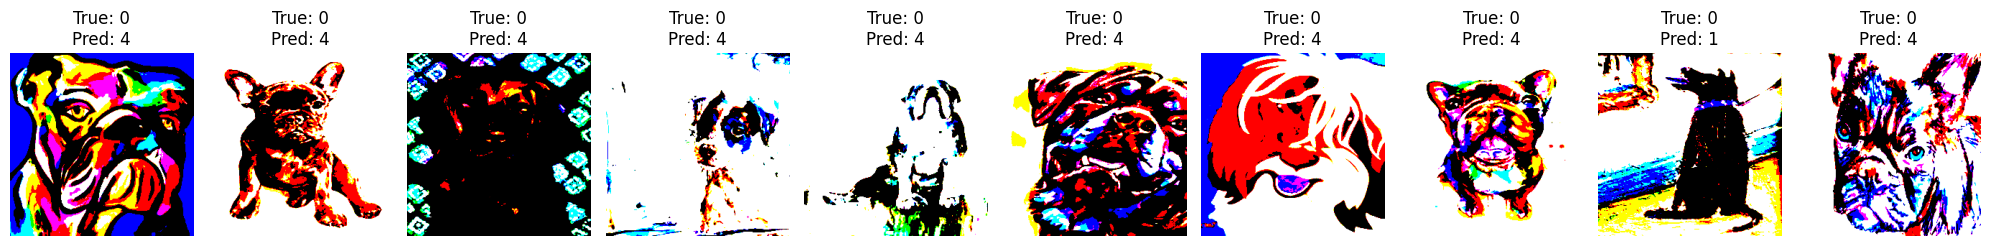

In [ ]:
import matplotlib.pyplot as plt

def display_mislabeled_images(model, dataset, num_samples=10):
    mislabeled_images = []
    corr_labels = []
    predicted_labels = []

    dataset.reset_pointer()
    while len(mislabeled_images) < num_samples:
        data_bat, data_labels = dataset.get_batch()
        if len(data_bat) == 0:  # End of the dataset
            break

        # Get predictions
        preds = model.predict(data_bat)

        # Find wrong indices in this batch
        mislabeled_indices = np.where(np.argmax(data_labels, axis=1) != np.argmax(preds, axis=1))[0]


        for index in mislabeled_indices:
            if len(mislabeled_images) < num_samples:
                mislabeled_images.append(data_bat[index])
                corr_labels.append(np.argmax(data_labels[index]))
                predicted_labels.append(np.argmax(preds[index]))
            else:
                break

    # Plot mislabeled images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4), tight_layout=True)
    for i, ax in enumerate(axes):
        ax.imshow(mislabeled_images[i])
        ax.set_title(f"True: {corr_labels[i]}\nPred: {predicted_labels[i]}")
        ax.axis('off')

    plt.show()

# Call the function to display the mislabeled images
display_mislabeled_images(model2, test_ds, num_samples=10)

### Data Augmentation with Style Transfer

In [ ]:
# [C12]
from PIL import Image
def part2_transfer(model, dataset, content_idx, style_idx, alpha):
    # [Your code here]
    # Tip: A large part of part1_inference can be applied here.
    content_img = get_image(dataset.list_of_file[content_idx])
    content_img = preprocess(content_img)
    content_img = tf.expand_dims(content_img,axis=0)

    style_img = get_image(dataset.list_of_file[style_idx])
    style_img = preprocess(style_img)
    style_img = tf.expand_dims(style_img,axis=0)

    alpha = tf.expand_dims(alpha,axis=0)

    output_img,adin = model.predict([content_img,style_img,alpha])
    output_img = tf.squeeze(output_img,axis=0)
    output_img = deprocess(output_img)
    output_img = array_to_img(output_img)
    # Instead of displaying the image, return it to be saved:
    return output_img

In [ ]:
# [C12]
def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = ALPHA, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    model = load_model(part1_load_path,custom_objects={'AdaIN':AdaIN})

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    df = dataset.data_table
    labeldiction = {label: list(indices) for label, indices in df.groupby('label').groups.items()} # [Your code here]
    stylediction = {style: list(indices) for style, indices in df.groupby('style').groups.items()} # [Your code here]

    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_indexs in labeldiction.items():
        for style, style_indexs in stylediction.items():
            for i in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_indexs), rng.choice(style_indexs)
                pair_set.add(pair)

                # Generate 1 sample
                img=part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                derived_name = f"{style}_{label}_{pair[0]}_{pair[1]}.png" # [Your code here]
                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                derived_entry = f"{derived_name}\t{style}\t{label}\n" # [Your code here]

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [ ]:
PART1_MODEL_PATH = os.path.join(data_path, '/content/drive/MyDrive/thridweight.h5') # [Change to your part_1 saved weight]
ALPHA = 0.75

OUTPUT_TSV = "classify/derived-data.tsv"
OUTPUT_DIR = "classify/derived-files"

# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [ ]:
!cat "$OUTPUT_TSV"

art_painting_dog_1252_518.png	art_painting	dog
art_painting_dog_435_470.png	art_painting	dog
art_painting_dog_1386_1579.png	art_painting	dog
art_painting_dog_1176_143.png	art_painting	dog
art_painting_dog_68_252.png	art_painting	dog
art_painting_dog_906_330.png	art_painting	dog
art_painting_dog_598_680.png	art_painting	dog
art_painting_dog_524_1619.png	art_painting	dog
art_painting_dog_499_1379.png	art_painting	dog
art_painting_dog_281_1565.png	art_painting	dog
art_painting_dog_411_765.png	art_painting	dog
art_painting_dog_673_1178.png	art_painting	dog
art_painting_dog_1045_1174.png	art_painting	dog
art_painting_dog_599_1079.png	art_painting	dog
art_painting_dog_1088_1556.png	art_painting	dog
art_painting_dog_805_326.png	art_painting	dog
art_painting_dog_1164_1241.png	art_painting	dog
art_painting_dog_568_1418.png	art_painting	dog
art_painting_dog_411_1527.png	art_painting	dog
art_painting_dog_684_142.png	art_painting	dog
cartoon_dog_766_253.png	cartoon	dog
cartoon_dog_155_88.png	carto

In [ ]:
# Generate the dataset:
part2_cleanup_augments(OUTPUT_DIR)
part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 20, alpha = ALPHA, random_state = 4211)

1/1 [==============================] - 0s 22ms/step


### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [ ]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

We can confirm the augmentation by looking at its distribution:

In [ ]:
part2_tally_samples(train2_ds)

,style,label,count
0,art_painting,dog,13
1,art_painting,elephant,13
2,art_painting,giraffe,231
3,art_painting,guitar,10
4,art_painting,horse,180
5,art_painting,house,11
6,art_painting,person,11
7,cartoon,dog,10
8,cartoon,elephant,13
9,cartoon,giraffe,12


Now we can train another classifier using the augmented data:

In [ ]:
PART2_SAVE_PATH_2 = "/content/drive/My Drive/Comp4211/weight/argu.h5" # [Change to your own path]
PART2_LOAD_PATH_2 = "/content/drive/My Drive/Comp4211/weight/argu.h5"
# [Call your train function here, training on train2_ds]
part2_train(model=model2, dataset=train2_ds, loss_fn=loss2, n_epochs=20, save_interval=10, save_path=PART2_SAVE_PATH_2, load_path=PART2_LOAD_PATH_2)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!

In [ ]:
# Evaluate on training dataset
training_accuracy2, training_confusion_matrix2 = part2_evaluate(model2, train_ds)
print("Training Dataset Evaluation:")
print(f"Accuracy: {training_accuracy2}")
print("Confusion Matrix:")
print(training_confusion_matrix2)

# Reset the dataset pointer before re-evaluating
train_ds.reset_pointer()

# Evaluate on test dataset
test_accuracy2, test_confusion_matrix2 = part2_evaluate(model2, test_ds)
print("\nTest Dataset Evaluation:")
print(f"Accuracy: {test_accuracy2}")
print("Confusion Matrix:")
print(test_confusion_matrix2)

Training Dataset Evaluation:
Accuracy: 0.8647836446762085
Confusion Matrix:
[[134 191   0   0   0   0   1]
 [ 11 244   0   0   0   0   1]
 [  4   4 256   1   0   0   0]
 [  0   0   0 144   0   0   0]
 [  1   6   0   0 192   0   0]
 [  0   0   0   0   0 239   0]
 [  1   3   0   0   0   1 230]]

Test Dataset Evaluation:
Accuracy: 0.5025436282157898
Confusion Matrix:
[[109 114  37  33  83  10  21]
 [ 16 237  38  17  50  16  12]
 [ 58  50 263  44  17  35   6]
 [  6  18  27 247  12  15  15]
 [ 65 112   9  39 121  23  13]
 [  4   6  45  66   8 256   1]
 [ 36  47  26  56  36  27 150]]
